# Tutorial: distribution with outliers

In this tutorial you will learn:

 - How to deal with outliers and non-gaussian distributions

In the "intrinsic distribution" tutorial, we fitted a gaussian distribution.
But maybe we do not want to make such a strong assumption -- we may not know the 
exact distribution. Perhaps it is skewed, has several sub-populations.
This can be tested by trying out different models.

Here, we check compare three scenarios:

1. baseline model: a gaussian distribution
2. baseline model + outlier model
3. heavy-tailed distribution

Here is our data:

In [1]:
import numpy as np
# velocity dispersions of dwarf galaxies by van Dokkum et al., Nature, 555, 629 https://arxiv.org/abs/1803.10237v1

values = np.array([15, 4, 2, 11, 1, -2, -1, -14, -39, -3])
values_lo = np.array([7, 16, 6, 3, 6, 5, 10, 6, 11, 13])
values_hi = np.array([7, 15, 8, 3, 6, 6, 10, 7, 14, 14])

n_data = len(values)


## Visualise the data

Lets plot the data first to see what is going on:



(-50.0, 50.0)

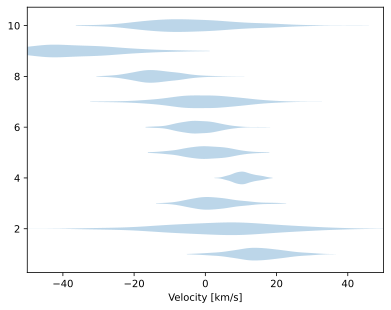

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

samples = []
for i in range(n_data):
    # draw normal random points
    u = np.random.normal(size=400)
    v = values[i] + np.where(u < 0, u * values_lo[i], u * values_hi[i])
    samples.append(v)

samples = np.array(samples)

plt.figure()
# for each galaxy, plot alittle cloud with its own colors
plt.violinplot(samples.transpose(), vert=False, showextrema=False)

xlabel = 'Velocity [km/s]'
plt.xlabel(xlabel)
plt.xlim(-50, 50);

## Models

### Gaussian

In [3]:
parameters = ['mean', 'scatter']

def prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0] * 200 - 100 # mean from -100 to +100
    params[1] = 10**(cube[1] * 2)   # scatter from 1 to 100
    return params

import scipy.stats

def log_likelihood(params):
    probs_samples = scipy.stats.norm(*params).pdf(samples)
    probs_objects = probs_samples.mean(axis=1)
    loglike = np.log(probs_objects + 1e-100).sum()
    return loglike

import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run()
sampler.print_results()


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 4993


[ultranest]   logZ = -43.53 +- 0.06279


[ultranest] Effective samples strategy satisfied (ESS = 1618.3, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)


[ultranest]   logZ error budget: single: 0.09 bs:0.06 tail:0.01 total:0.06 required:<0.50


[ultranest] done iterating.



logZ = -43.520 +- 0.140
  single instance: logZ = -43.520 +- 0.087
  bootstrapped   : logZ = -43.527 +- 0.140
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mean                0.1 +- 4.0
    scatter             8.8 +- 4.5


### Gaussian + Outliers

In [4]:
parameters2 = ['mean', 'scatter', 'w_outlier']

def prior_transform2(cube):
    params = cube.copy()
    params[0] = cube[0] * 200 - 100 # mean from -100 to +100
    params[1] = 10**(cube[1] * 2)   # scatter from 1 to 100
    params[2] = (cube[2] * 0.2)     # fraction of outliers: allow 0-20%
    return params

def log_likelihood2(params):
    mean, scatter, weight = params
    
    # compute probability if following distribution
    probs_samples = scipy.stats.norm(mean, scatter).pdf(samples)
    # compute probability density, if outlier:
    prob_outlier = scipy.stats.uniform(-100, 200).pdf(samples)
    
    # combine the two populations with weight:
    probs_samples = probs_samples * (1 - weight) + weight * prob_outlier
    
    # average within each object (logical OR)
    probs_objects = probs_samples.mean(axis=1)
    # multiply across object (logical AND)
    loglike = np.log(probs_objects + 1e-100).sum()
    return loglike


sampler2 = ultranest.ReactiveNestedSampler(parameters2, log_likelihood2, prior_transform2)
result2 = sampler2.run()
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 7274


[ultranest]   logZ = -44.25 +- 0.08687


[ultranest] Effective samples strategy satisfied (ESS = 1801.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.25, need <0.5)


[ultranest]   logZ error budget: single: 0.09 bs:0.09 tail:0.01 total:0.09 required:<0.50


[ultranest] done iterating.



logZ = -44.240 +- 0.255
  single instance: logZ = -44.240 +- 0.089
  bootstrapped   : logZ = -44.255 +- 0.254
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 15.0 iterations

    mean                0.7 +- 4.3
    scatter             7.8 +- 4.6
    w_outlier           0.086 +- 0.057


### Heavy-tailed distribution

In [5]:
parameters3 = ['mean', 'scatter', 'dof']

def prior_transform3(cube):
    params = cube.copy()
    params[0] = cube[0] * 200 - 100 # mean from -100 to +100
    params[1] = 10**(cube[1] * 2)   # scatter from 1 to 100
    params[2] = 10**(cube[2])       # degrees of freedom in student-t: 1 (heavy tails)..10 (gaussian)
    return params

def log_likelihood3(params):
    mean, scatter, dof = params
    # compute student-t probability
    probs_samples = scipy.stats.t(loc=mean, scale=scatter, df=dof).pdf(samples)
    # average within each object (logical OR)
    probs_objects = probs_samples.mean(axis=1)
    # multiply across object (logical AND)
    loglike = np.log(probs_objects + 1e-100).sum()
    return loglike

sampler3 = ultranest.ReactiveNestedSampler(parameters3, log_likelihood3, prior_transform3)
sampler3.run()
sampler3.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 6852


[ultranest]   logZ = -43.99 +- 0.07109


[ultranest] Effective samples strategy satisfied (ESS = 1633.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.50


[ultranest] done iterating.



logZ = -43.992 +- 0.194
  single instance: logZ = -43.992 +- 0.091
  bootstrapped   : logZ = -43.991 +- 0.194
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 22.0 iterations

    mean                0.5 +- 4.0
    scatter             6.8 +- 4.1
    dof                 4.1 +- 2.5


## Comparing the models

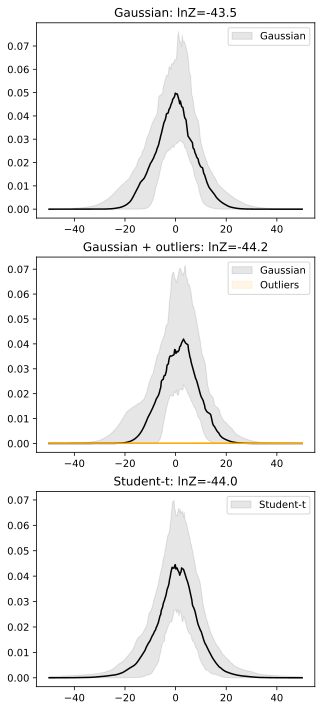

In [6]:
plt.figure(figsize=(5, 12))
plt.xlabel(xlabel)

from ultranest.plot import PredictionBand
x = np.linspace(-50, 50, 400)


plt.subplot(3, 1, 1)
band = PredictionBand(x)

for params in sampler.results['samples'][:40]:
    mean, scatter = params
    band.add(scipy.stats.norm(mean, scatter).pdf(x))

band.shade(color='k', alpha=0.1, label="Gaussian")
band.line(color='k')
plt.legend(loc='upper right')
plt.title("Gaussian: lnZ=%.1f" % sampler.results['logz'])

plt.subplot(3, 1, 2)
band = PredictionBand(x)
bando = PredictionBand(x)

for params in sampler2.results['samples'][:40]:
    mean, scatter, outlier_weight = params
    band.add(scipy.stats.norm(mean, scatter).pdf(x) * (1 - outlier_weight))
    bando.add(scipy.stats.norm(-100, 200).pdf(x) * outlier_weight)

band.shade(color='k', alpha=0.1, label="Gaussian")
band.line(color='k');
bando.shade(color='orange', alpha=0.1, label="Outliers")
bando.line(color='orange');
plt.legend(loc='upper right')
plt.title("Gaussian + outliers: lnZ=%.1f" % sampler2.results['logz'])

plt.subplot(3, 1, 3)

for params in sampler3.results['samples'][:40]:
    mean, scatter, df = params
    band.add(scipy.stats.t(loc=mean, scale=scatter, df=df).pdf(x))

band.shade(color='k', alpha=0.1, label='Student-t')
band.line(color='k');
plt.title("Student-t: lnZ=%.1f" % sampler3.results['logz'])
plt.legend(loc='upper right');



The models look very similar in their predictions, and their lnZ values are also quite close.
So I would not have a strong preference in any direction.

Lets compare the posterior distributions with getdist:

Removed no burn in
Removed no burn in
Removed no burn in


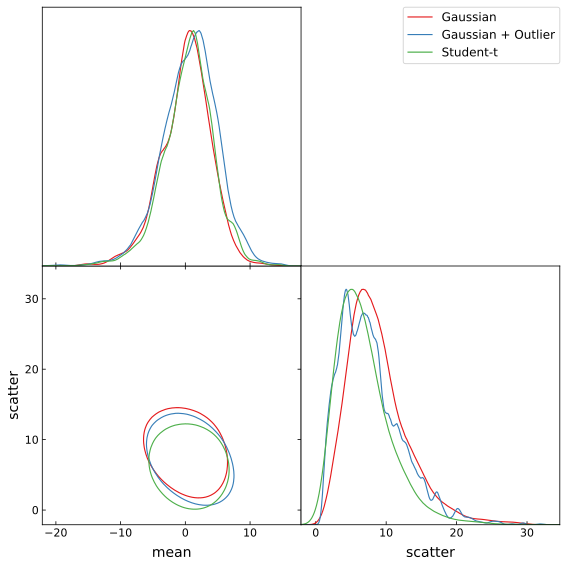

In [7]:
from getdist import MCSamples, plots

samples_g = MCSamples(samples=sampler.results['samples'], 
                       names=sampler.results['paramnames'], 
                       label='Gaussian',
                       settings=dict(smooth_scale_2D=3), sampler='nested')
samples_o = MCSamples(samples=sampler2.results['samples'][:,:2], 
                       names=sampler2.results['paramnames'][:2], 
                       label='Gaussian + Outlier',
                       settings=dict(smooth_scale_2D=3), sampler='nested')
samples_t = MCSamples(samples=sampler3.results['samples'][:,:2], 
                       names=sampler3.results['paramnames'][:2], 
                       label='Student-t',
                       settings=dict(smooth_scale_2D=3), sampler='nested')

mcsamples = [samples_g, samples_o, samples_t]

g = plots.get_subplot_plotter(width_inch=8)
g.settings.num_plot_contours = 1
g.triangle_plot(mcsamples, filled=False, contour_colors=plt.cm.Set1.colors)


### Next

1. Try adding an outlier.
2. Try adjusting the number of live points (min_num_live_points) and effective sample size (min_ess) parameters above to decrease the uncertainties.
3. Try varying the prior ranges.
4. Continue with the other tutorials and explore other UltraNest features